In [30]:
import netCDF4
import pyproj
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import tqdm.notebook

# xr.set_options(display_style='html')


In [54]:
ds = netCDF4.Dataset('../data/SDN_2015-09_TS_MedSea_QC_done_v2_130ef42_1.nc')
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    comment: ODV NetCDF Export File V2.0
    Creator: root@525bb4627be0
    CreateTime: 2020-01-16T08:50:44
    Software: Web Ocean Data View 5.1.8 - web_server: 14 - 64 bit (Linux)
    source: /var/www/html/ODV_Data/SDN_2015-09_TS_MedSea_QC_done_v2.odv
    SourceLastModified: 2015-07-21T11:19:34
    DataField: Ocean
    DataType: Profiles
    featureType: profile
    dimensions(sizes): N_STATIONS(4608), N_SAMPLES(14175), STRING34(34), STRING23(23)
    variables(dimensions): |S1 metavar1(N_STATIONS,STRING23), |S1 metavar2(N_STATIONS,STRING34), |S1 metavar3(N_STATIONS), float32 longitude(N_STATIONS), float32 latitude(N_STATIONS), float64 date_time(N_STATIONS), float32 var1(N_STATIONS,N_SAMPLES), int8 var1_qc(N_STATIONS,N_SAMPLES), float32 var2(N_STATIONS,N_SAMPLES), int8 var2_qc(N_STATIONS,N_SAMPLES), float32 var3(N_STATIONS,N_SAMPLES), int8 var3_qc(N_STATIONS,N_SAMPLES)
    gro

In [3]:
ds.variables['metavar2']

<class 'netCDF4._netCDF4.Variable'>
|S1 metavar2(N_STATIONS, STRING34)
    long_name: Station
    units: 
    comment: 
unlimited dimensions: 
current shape = (4608, 34)
filling on, default _FillValue of   used

In [4]:
vars = {}
for name in ds.variables:
    var = ds.variables[name]
    if var.long_name:
        column = var.long_name
    else:
        column = name

    if var.dtype == 'S1' and len(var.dimensions) == 2:
        vars[column] = netCDF4.chartostring(var[:])
    elif len(var.dimensions) > 1:
        print('skipping',  name)
        continue
    else:
        vars[column] = var[:]
df = pd.DataFrame(vars)
df


skipping var1
skipping var1_qc
skipping var2
skipping var2_qc
skipping var3
skipping var3_qc


,Cruise,Station,Type,Longitude,Latitude,Decimal Gregorian Days of the station
0,64PE159,59/1_BE,b'C',19.549999,38.733002,140.524306
1,64PE159,67/1_BE,b'C',19.684999,36.875000,141.552083
2,64PE159,72/1_BE,b'C',21.645000,35.938999,142.368056
3,64PE159,81/1_BE,b'C',21.368999,35.292000,143.670833
4,64PE159,82/1_BE,b'C',20.546000,34.820000,144.477083
...,...,...,...,...,...,...
4603,TARA_20091122Z,TARA_20091123T1242Z_025_EVENT_CAST,b'C',19.380699,39.408501,3614.528322
4604,TARA_20091122Z,TARA_20091123T0916Z_025_EVENT_CAST,b'C',19.391001,39.387699,3614.384965
4605,TARA_20091122Z,TARA_20091122Z_UDW_EVENT_CSSS,b'C',19.106649,40.101780,3613.000000
4606,TARA_20091122Z,TARA_20091124T1019Z_026_EVENT_CAST,b'C',20.200300,38.396599,3615.428461


In [42]:
ds.variables['date_time']


<class 'netCDF4._netCDF4.Variable'>
float64 date_time(N_STATIONS)
    long_name: Decimal Gregorian Days of the station
    standard_name: time
    units: days since 2000-01-01 00:00:00 UTC
    comment: Relative Gregorian Days with decimal part
    C_format: %.5f
    FORTRAN_format: F12.5
    _FillValue: -10000000000.0
unlimited dimensions: 
current shape = (4608,)
filling on

In [32]:
dfs = []
var_names = ['var1', 'var2', 'var3']
arrs  = {}
for var_name in var_names:
    arrs[var_name] = ds.variables[var_name][:]

for (i, row) in tqdm.notebook.tqdm(df.iterrows()):
    variables = {
        ds.variables[var_name].long_name: arrs[var_name][i, :]
        for var_name
        in var_names
    }
    df_i = pd.DataFrame(variables)
    # drop  records that are all none
    df_i = df_i.dropna(how='all')
    #  add records
    df_i = df_i.assign(**row)
    dfs.append(df_i)
long_df = pd.concat(dfs)

In [65]:
renames = {
    'Depth': 'd', 
    'ITS-90 water temperature': 'T',
    'Water body salinity': 'S', 
    'Cruise': 'c_id',
    'Station': 's_id', 
    'Type': 'type', 
    'Longitude': 'lon', 
    'Latitude': 'lat',
    'Decimal Gregorian Days of the station': 't'
}
long_df = long_df.rename(renames, axis=1)
long_df['d'] *= -1
long_df.head(n=100000).to_json('../data/med_test.json', orient='split', double_precision=3, index=False)

In [60]:
long_df.to_json?

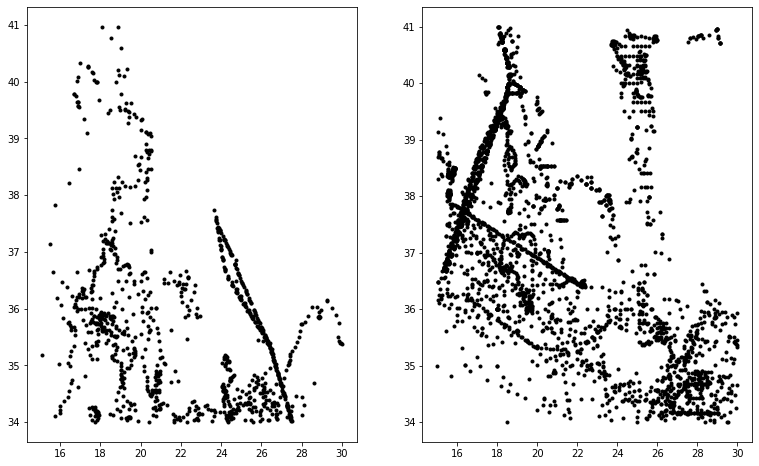

In [5]:
selected_B = df[df.Type == b'B']
selected_C = df[df.Type == b'C']
fig, axes = plt.subplots(figsize=(13, 8), ncols=2)
axes[0].plot(selected_B.Longitude, selected_B.Latitude, 'k.')
axes[1].plot(selected_C.Longitude, selected_C.Latitude, 'k.')

In [6]:
df[df.Cruise == selected_B.iloc[0].Cruise]

,Cruise,Station,Type,Longitude,Latitude,Decimal Gregorian Days of the station
735,NCMR07XB,03320,b'B',23.961330,37.367168,20.838889
736,NCMR07XB,03330,b'B',24.178829,37.205830,20.874306
737,NCMR07XB,03340,b'B',24.317169,37.099331,20.897222
738,NCMR07XB,03350,b'B',24.455170,36.988171,20.920833
739,NCMR07XB,03360,b'B',24.682329,36.789829,20.963194
740,NCMR07XB,03370,b'B',24.872169,36.598671,20.999306
741,NCMR07XB,03380,b'B',25.091330,36.420330,21.038194
742,NCMR07XB,03400,b'B',25.290831,36.261829,21.070139
743,NCMR07XB,03410,b'B',25.483330,36.099998,21.102083
744,NCMR07XB,03420,b'B',25.651670,35.969669,21.133333


In [7]:
B =  df[df.Cruise == selected_B.iloc[0].Cruise]
C =  df[df.Cruise == selected_C.iloc[0].Cruise]
B.head()

,Cruise,Station,Type,Longitude,Latitude,Decimal Gregorian Days of the station
735,NCMR07XB,03320,b'B',23.961330,37.367168,20.838889
736,NCMR07XB,03330,b'B',24.178829,37.205830,20.874306
737,NCMR07XB,03340,b'B',24.317169,37.099331,20.897222
738,NCMR07XB,03350,b'B',24.455170,36.988171,20.920833
739,NCMR07XB,03360,b'B',24.682329,36.789829,20.963194


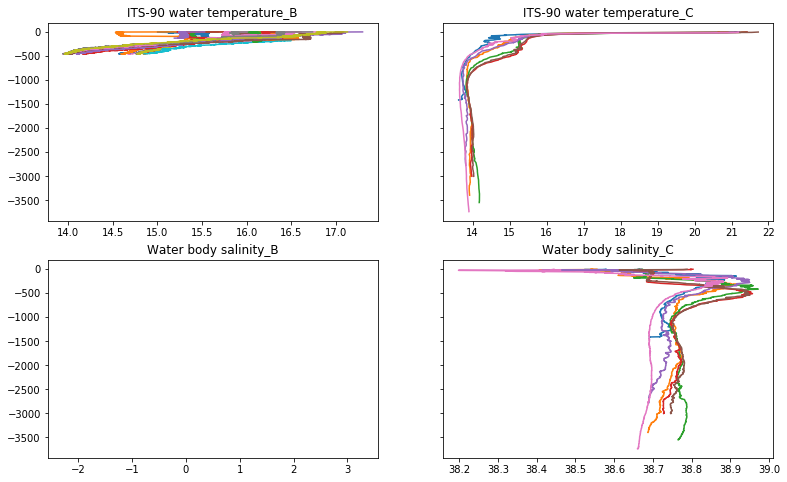

In [8]:
fig, axes = plt.subplots(nrows=2,  ncols=2, figsize=(13,  8), sharey=True)

for i, name in  enumerate(['var2', 'var3']):

    for depth, x in zip(ds.variables['var1'][B.index], ds.variables[name][B.index]):
        axes[i, 0].set_title(ds.variables[name].long_name  + '_' + 'B')
        axes[i, 0].plot(x, -depth)
    for depth, x in zip(ds.variables['var1'][C.index], ds.variables[name][C.index]):
        axes[i, 1].set_title(ds.variables[name].long_name  + '_' + 'C')
        axes[i, 1].plot(x, -depth)


(19, 14175)

masked_array(data=[0.9929999709129333, 1.9850000143051147,
                   2.9779999256134033, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-10000000000.0,
            dtype=float32)

In [10]:
%%timeit
np.argmax(cdi_ids == 'FS35196900000_90460_H13')

10.2 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
var_names = [
    name 
    for name, var 
    in ds.variables.items() 
    if name.startswith('var') and not '_' in name
]

# add the variables to the list
variables = {}
for var_name in var_names:
    var = ds.variables[var_name]
    variables[var.long_name] = var[idx]

df = pd.DataFrame(data=variables)
# get rid of missing data
df = df.dropna(how='all')

# get metadata
date_nums = ds.variables['date_time'][idx]
date_units = ds.variables['date_time'].units
date = netCDF4.num2date(date_nums, date_units)
records = df.to_json(orient='records')
response = {
    "series": records,
    "meta": {
        "date": date
    }
}
response

{'series': '[{"Depth":0.0,"ITS-90 water temperature":22.7000007629,"Water body salinity":null},{"Depth":5.0,"ITS-90 water temperature":21.7999992371,"Water body salinity":null},{"Depth":10.0,"ITS-90 water temperature":21.7000007629,"Water body salinity":null},{"Depth":30.0,"ITS-90 water temperature":21.7000007629,"Water body salinity":null}]',
 'meta': {'date': datetime.datetime(1969, 11, 9, 13, 0)}}

In [12]:
date_nums.shape
ds.variables['var2'].shape

(451610, 9816)

In [13]:
ds.variables['var1']

<class 'netCDF4._netCDF4.Variable'>
float32 var1(N_STATIONS, N_SAMPLES)
    long_name: Depth
    units: m
    comment: Codes: SDN:P01::ADEPZZ01 SDN:P06::ULAA
    ancillary_variables: var1_qc var1_err
    C_format: %.2f
    FORTRAN_format: F12.2
    _FillValue: -10000000000.0
unlimited dimensions: 
current shape = (451610, 9816)
filling on